In [1]:
import sys
sys.path.append('..')
sys.path.append('/Users/jh7685/Documents/Projects/pysurfer')
from pysurfer.mgz_helper import map_values_as_mgz
from pysurfer.mgz_helper import load_mgzs, read_label
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sfp_nsdsyn import *
from timeit import default_timer as timer
import warnings
from itertools import product
from scipy import optimize
warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

In [64]:
nsd_dir ='/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset'
output_dir='/Volumes/server/Projects/sfp_nsd/derivatives'
fs_subj_dir='/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset/nsddata/freesurfer'

In [65]:
roi_list = ['V1v', 'V1d', 'V2v','V2d', 'V3v','V3d', 'hV4', 'aFFA', 'pFFA', 'PPA']


# Load beta values

In [3]:
subj='subj01'
hemi='lh'
betas = os.path.join(nsd_dir, 'nsddata_betas', 'ppdata', f'{subj}', 'nativesurface', 'nsdsyntheticbetas_fithrf_GLMdenoise_RR', f'{hemi}.betas_nsdsynthetic.hdf5')
design_mat=os.path.join(nsd_dir, 'nsddata', 'experiments', 'nsdsynthetic', 'nsdsynthetic_expdesign.mat')
task_keys=['fixation_task','memory_task']
stim_info=os.path.join(nsd_dir, 'nsdsyn_stim_description.csv')
task_average=True
eccentricity_path= os.path.join(nsd_dir, 'nsddata', 'freesurfer', f'{subj}', 'label',  f'{hemi}.prfeccentricity.mgz')

In [4]:
betas_df = sfm.get_whole_brain_betas(betas_path=betas, design_mat_path=design_mat,
                          stim_info_path=stim_info,
                          task_keys=task_keys, task_average=task_average, eccentricity_path=eccentricity_path,
                          x_axis='voxel', y_axis='stim_idx', long_format=True, reference_frame='relative')
betas_df = betas_df.query('~names.str.contains("intermediate").values')

# Test with V1 voxels

In [6]:
label_path=f'/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset/nsddata/freesurfer/subj01/label/{hemi}.V1v.label'
V1_voxels = read_label(label_path, read_header=False, index_only=True)
V1_df = betas_df.query('voxel in @V1_voxels & 0.49 < eccentricity < 4.2')

In [43]:
# Define bins and labels for categorization
bins = [0.5, 1, 2, 4]  # Adjust bin edges as needed
labels = ['0.5-1', '1-2', '2-4']

# Use pd.cut to create a new column based on categorization
V1_df['eccentricity bin'] = pd.cut(V1_df['eccentricity'], bins=bins, labels=labels, right=False)
avg_V1_df = V1_df.groupby(['freq_lvl', 'voxel']).mean().reset_index()

In [56]:
random_voxels = utils.pick_random_voxels(avg_V1_df.voxel.unique(), n=100)
test = avg_V1_df.query('voxel in @random_voxels')
initial_params = np.random.random(3) + [0, 0.5, 0.5]

In [57]:
p_opt = pd.DataFrame({})
for v in random_voxels:
    v_tmp = test.query('voxel == @v')
    tmp_p_opt, _ = tuning.fit_logGaussian_curves(v_tmp, x='local_sf', y='betas',
                                                 initial_params=initial_params, goodness_of_fit=True)
    tmp_p_opt['voxel'] = v
    p_opt = pd.concat((tmp_p_opt, p_opt))
p_opt = p_opt.set_index('voxel').reset_index()

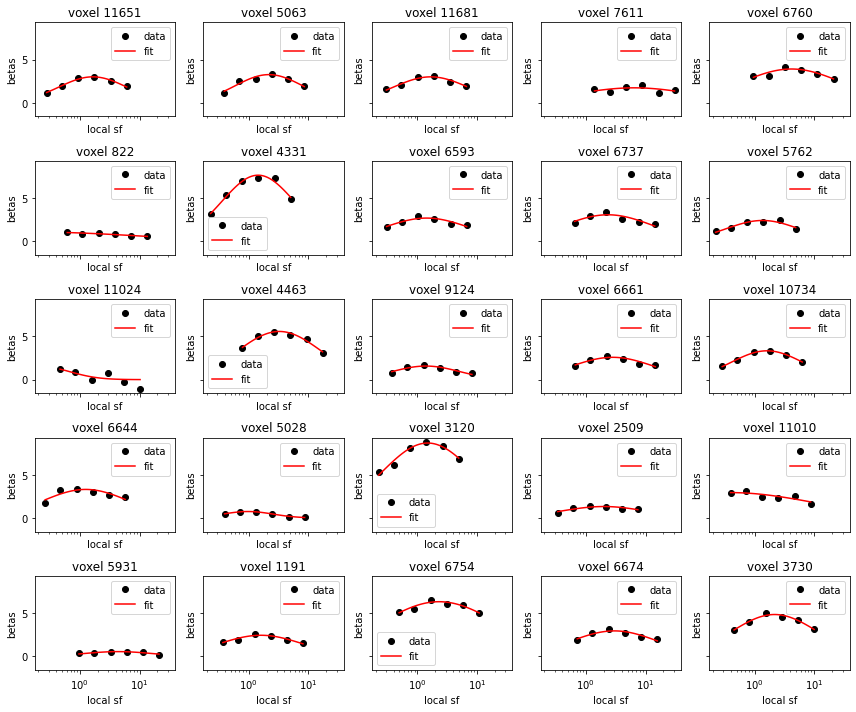

In [59]:
fig, axes = plt.subplots(5,5, sharex=True, sharey=True, figsize=(6*2,5*2))
# Flatten the axes array for easy iteration
flat_axes = axes.flatten()

for i, v in enumerate(random_voxels[:25]):
    v_tmp = test.query('voxel == @v')
    p_opt_tmp = p_opt.query('voxel == @v')
    tuning.plot_logGaussian_fit(v_tmp, x, y, p_opt_tmp, flat_axes[i], ax_title=f'voxel {v}')
#utils.save_fig(save_path)

In [61]:
p_opt

,voxel,amp,mode,sigma,r2,rmse
0,7404,1.350529,1.370510,2.419318,0.843712,0.083962
1,1555,0.885343,1.101821,1.721675,0.810411,0.089869
2,8315,1.635823,2.585323,2.363319,0.746243,0.133993
3,2084,4.622357,1.994003,2.269806,0.989674,0.070656
4,2621,2.824165,2.425596,2.014328,0.924723,0.146504
...,...,...,...,...,...,...
95,6760,3.910982,4.157021,2.815982,0.767329,0.226645
96,7611,1.736354,6.459768,3.262275,0.184107,0.282596
97,11681,3.004273,1.681728,2.075852,0.949694,0.120619
98,5063,3.262106,2.191706,1.876917,0.933389,0.180826


In [67]:
test_df = '/Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/voxel-tuning/nsdsyn/method-curvefit_hemi-lh_sub-subj06_frame-relative.hdf'
test_df = pd.read_hdf(test_df)

In [72]:
sn='subj01'
all_rois_df = pd.DataFrame({})
for hemi, roi in product(['lh','rh'], roi_list[:2]):
    # Filter the dataframe to only include rows where 'voxel' is in V1_label
    label_path = os.path.join(fs_subj_dir, sn, 'label', f'{hemi}.{roi}.label')
    roi_voxels = read_label(label_path, read_header=False, index_only=True)
    tmp = test_df[test_df['voxel'].isin(roi_voxels)]
    tmp['ROI'] = roi
    tmp['hemi'] = hemi
    assert len(tmp) == len(roi_voxels)
    all_rois_df = pd.concat((all_rois_df, tmp))


# All voxels

In [29]:
avg_betas_df = betas_df.groupby(['voxel', 'freq_lvl']).mean().reset_index()
avg_betas_df = avg_betas_df[['voxel','freq_lvl','betas','local_sf']]

In [32]:
random_voxels = utils.pick_random_voxels(avg_betas_df.voxel.unique(), n=6)

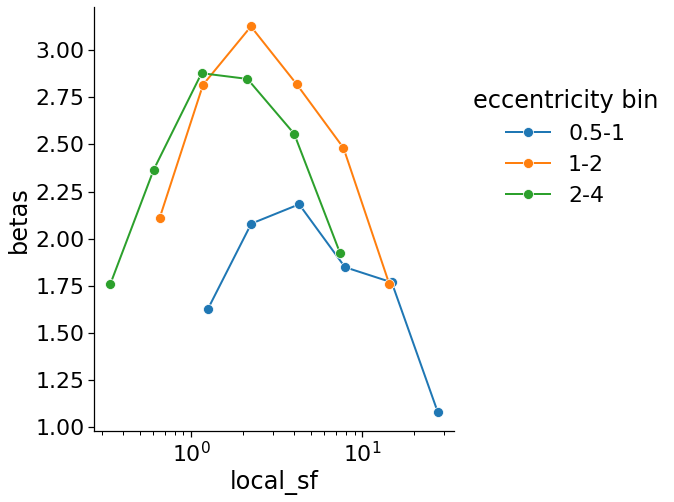

In [8]:
#save_path = os.path.join(output_dir, 'figures', 'tmp', 'random_voxel_datapoints.png')
vis1D.plot_curves_sns(avg_V1_df,
                      x='local_sf', y='betas', height=7,
                      hue='eccentricity bin',
                      to_logscale=True, save_path=None)

In [34]:
test = avg_betas_df.query('voxel in @random_voxels')
initial_params = np.random.random(3) + [0, 0.5, 0.5]

In [35]:
from timeit import default_timer as timer
p_opt = pd.DataFrame({})
for v in random_voxels:
    start = timer()
    v_tmp = test.query('voxel == @v')
    tmp, _ = tuning.fit_logGaussian_curves(v_tmp, x='local_sf', y='betas',
                                  initial_params=initial_params)
    print(f'Elapsed time: {np.round(timer() - start, 2)} sec')
    tmp['voxel'] = v
    p_opt = pd.concat((tmp, p_opt))
p_opt = p_opt.set_index('voxel').reset_index()

Elapsed time: 0.01 sec
Elapsed time: 0.01 sec
Elapsed time: 0.0 sec
Elapsed time: 0.0 sec
Elapsed time: 0.02 sec
Elapsed time: 0.01 sec
